In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
# !pip install PyQt5
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']


In [36]:
# imports 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import time
import PyQt5
seed = 1
np.random.seed(seed)
# %matplotlib inline 
# %matplotlib notebook 

In [59]:
# this is equation 29 from main paper
def vf(x):
    y = [-x[:,1], x[:,0] + (1-x[:,0]**2)*x[:,1]]
    return y

#domain used
n_points = 90
omega_domain = np.array([np.random.uniform(-1.6, 1.6,n_points), np.random.uniform(-4,4,n_points)]).T
m = 100
d = 2
w = tf.Variable(tf.random.normal((d,m), 0,1), trainable = False)
b = tf.Variable(tf.random.uniform((m,), 0, np.pi), trainable = False)
a = tf.Variable(tf.zeros((m,)), trainable=True)

In [38]:
# define the part of the loss function implementing the PDE
@tf.function
def grad_loss_eq(gradx, x_batch_train, vf_batch_train):
    # LHS of eq 6.4
    g_loss = kb.sum(kb.square( kb.sum(gradx*vf_batch_train,axis=1) + kb.sum(kb.square(x_batch_train),axis=1)))
    return g_loss

In [69]:
inputdim = 2
def get_regularised_bn_mlp(input_shape, hidden_units, l2_reg_coeff = None, dropout_rate = None):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape, name = 'state')
    # h = inputs
    h = tf.keras.layers.Dense(200, activation=tf.math.cos, 
                              kernel_initializer=tf.random_normal_initializer,
                              bias_initializer= tf.random_uniform_initializer(0, np.pi))(inputs)
    for units in hidden_units:
        # h = tf.keras.layers.Dense(units, activation='selu', 
        #                           kernel_regularizer=tf.keras.regularizers.l2(l2_reg_coeff))(h)
        h = tf.keras.layers.Dense(units, activation='linear')(h)
        # h = tf.keras.layers.BatchNormalization()(h)
        # h = tf.keras.layers.Dropout(dropout_rate)(h)
    # outputs = tf.keras.layers.Dense(10, activation=None)(h)
    outputs = tf.keras.layers.Dense(1, activation=None, name = 'Lyapunov_function')(h)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = get_regularised_bn_mlp(input_shape=inputdim, hidden_units=[])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 200)               600       
                                                                 
 Lyapunov_function (Dense)   (None, 1)                 201       
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [70]:
# define the training data
# data = 2.*np.random.random((200000, inputdim)) - 1;  
data = omega_domain
tdata = tf.convert_to_tensor(data, dtype=tf.float32)

vfdata = vf(data)
tdata   = tf.convert_to_tensor(data,   dtype=tf.float32)
tvf     = kb.transpose(tf.convert_to_tensor(vfdata, dtype=tf.float32))

train_dataset_raw = tf.data.Dataset.from_tensor_slices((tdata, tvf))
train_dataset_raw.element_spec

(TensorSpec(shape=(2,), dtype=tf.float32, name=None),
 TensorSpec(shape=(2,), dtype=tf.float32, name=None))

In [71]:
# def shuffle_and_batch_dataset(dataset, batch_size, shuffle_buffer=None):
#     """
#     This function is used to shuffle and batch the dataset, using shuffle_buffer
#     and batch_size.
#     Your function should return the shuffled and batched Dataset.
#     """
#     if shuffle_buffer:
#         dataset = dataset.shuffle(buffer_size=shuffle_buffer)
        
#     dataset = dataset.batch(batch_size)

#     return(dataset)

# train_dataset = shuffle_and_batch_dataset(train_dataset_raw, 32, shuffle_buffer=1024)
# train_dataset.element_spec

In [72]:
# this function performs the optimization for one batch of the data
@tf.function
def train_batch(x_batch_train, vf_batch_train):

# start gradient recording for derivative w.r.t. model parameters
  with tf.GradientTape() as tape:

    # evaluate model
    # try trainable = False
    logits = model(x_batch_train, training=True)

    # start gradient recording for derivative w.r.t. x
    with tf.GradientTape() as tapex:

      # prepare for evaluation of x-derivative
      tapex.watch(x_batch_train)
      logits2 = model(x_batch_train)

      # evaluate x-derivative
      gradx = tapex.gradient(logits2, x_batch_train)

      # evaluate PDE part of loss function
      gloss = grad_loss_eq(gradx, x_batch_train, vf_batch_train)
      loss_value =  gradweight * gloss

    # evaluate derivative w.r.t. model parameters
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent optimizer
    opt.apply_gradients(zip(grads, model.trainable_weights))

    return(loss_value,gloss)

In [73]:
# this function performs the optimization for a train step
@tf.function
def train_step(x_batch_train, vf_batch_train):

# start gradient recording for derivative w.r.t. model parameters
  with tf.GradientTape() as tape:

    # evaluate model
    # try trainable = False
    logits = model(x_batch_train, training=False)

    # start gradient recording for derivative w.r.t. x
    with tf.GradientTape() as tapex:

      # prepare for evaluation of x-derivative
      tapex.watch(x_batch_train)
      logits2 = model(x_batch_train)

      # evaluate x-derivative
      gradx = tapex.gradient(logits2, x_batch_train)

      # evaluate PDE part of loss function
      gloss = grad_loss_eq(gradx, x_batch_train, vf_batch_train)
      loss_value =  gradweight * gloss

    # evaluate derivative w.r.t. model parameters
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent optimizer
    opt.apply_gradients(zip(grads, model.trainable_weights))

    return(loss_value,gloss)

In [74]:
# This is for the batch training
epochs = 100
tol = 1e-5
batch_size = 32
buff = 1024
gradweight = 2
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

all_loss_values = []

# loop through the epochs
for epoch in range(epochs):

  # prepare dataset
  train_dataset = train_dataset_raw.shuffle(buffer_size=buff).batch(batch_size)

  # initialize error variables, mlv=maximum (L_infty), slv = L_1
  mlv = 0.0
  slv = 0.0
  
  # Iterate over the batches of the dataset
  for step, (x_batch_train, vf_batch_train) in enumerate(train_dataset):

    # call optimization routine
    [loss_value,gloss] = train_batch(x_batch_train, vf_batch_train)
    all_loss_values.append(loss_value.numpy())


    # update errors
    mlv = kb.max([mlv,loss_value],0)
    slv = slv + loss_value

    # # print log information every 100 steps
    # if step % 100 == 0:
    #   print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv), end = '\r')

  # print log information at end of epoch    
  # print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv))
  if epoch % 10 == 0:
    print('epoch %2s, loss %10.6f' % (epoch, float(loss_value)))


  # terminate if L_infty error is sufficiently small
  if mlv < tol:
    print('op')
    break

epoch  0, loss 1663.551880
epoch 10, loss 1272.928711
epoch 20, loss 1112.863281
epoch 30, loss 1656.967651
epoch 40, loss 1785.858032
epoch 50, loss 1203.234009
epoch 60, loss 1020.578979
epoch 70, loss 921.801331
epoch 80, loss 865.823425
epoch 90, loss 410.764313


In [75]:
 # This is for the training step
epochs = 50
tol = 1e-5
batch_size = 90
buff = 1024
gradweight = 2


def shuffle_and_batch_dataset(dataset, batch_size, shuffle_buffer=None):
    """
    This function is used to shuffle and batch the dataset, using shuffle_buffer
    and batch_size.
    Your function should return the shuffled and batched Dataset.
    """
    if shuffle_buffer:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)
        
    dataset = dataset.batch(batch_size)

    return(dataset)

train_dataset = shuffle_and_batch_dataset(train_dataset_raw, batch_size, shuffle_buffer=buff)

all_loss_values = []

start = time.perf_counter()

# loop through the epochs
for epoch in range(epochs):

  # initialize error variables, mlv=maximum (L_infty), slv = L_1
  mlv = 0.0
  slv = 0.0
  
  # Iterate over the batches of the dataset
  for step, (x_batch_train, vf_batch_train) in enumerate(train_dataset):

    # call optimization routine
    [loss_value,gloss] = train_step(x_batch_train, vf_batch_train)
    all_loss_values.append(loss_value.numpy())


    # update errors
    mlv = kb.max([mlv,loss_value],0)
    slv = slv + loss_value

    # # print log information every 100 steps
    # if step % 100 == 0:
    #   print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv), end = '\r')

  # print log information at end of epoch    
  # print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv))
  if epoch % 10 == 0:
    print('epoch %2s, loss %10.6f' % (epoch, float(loss_value)))


  # terminate if L_infty error is sufficiently small
  if mlv < tol:
    print('op')
    break

print("End of training, time: {:.4f}".format(time.perf_counter() - start))

epoch  0, loss 1531.893066
epoch 10, loss 1399.849976
epoch 20, loss 1267.980225
epoch 30, loss 1165.594971
epoch 40, loss 1088.583252
End of training, time: 0.9794


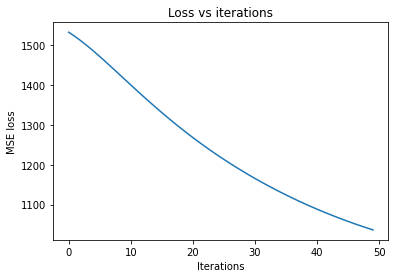

In [76]:
plt.plot(all_loss_values)
plt.title("Loss vs iterations")
plt.xlabel("Iterations")
plt.ylabel("MSE loss")
plt.show()

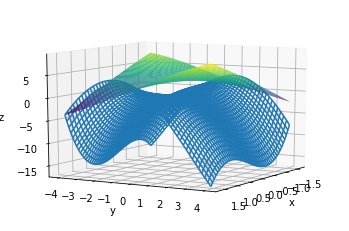

In [77]:
###### plot result ######

# define resolution
numpoints = 50

# define plotting range and mesh
x = np.linspace(-1.6, 1.6, numpoints)
y = np.linspace(-4, 4, numpoints)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((numpoints**2,inputdim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

# evaluate model (= Lyapunov function values V)
Ep = model.predict(DT)

# convert point vector to tensor for evaluating x-derivative
tDT = tf.convert_to_tensor(DT, dtype=tf.float32)

# evaluate gradients DV of Lyapunov function
with tf.GradientTape() as tape:
    tape.watch(tDT)
    ypm = model(tDT)
    grads = tape.gradient(ypm, tDT)

# compute orbital derivative DVf
Ee = kb.sum(grads*kb.transpose(tf.convert_to_tensor(vf(DT), dtype=tf.float32)), axis=1)

# copy V and DVf values into plottable format
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        Ze[i,j] = Ee[c]
        Zp[i,j] = Ep[c]
        c = c+1;

# define figure
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# plot values V
ax.plot_surface(X, Y, Zp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

# plot orbital derivative DVf
ax.plot_wireframe(X, Y, Ze, rstride=1, cstride=1)

# change angles to see graph more clearly
ax.view_init(-140, 60)
ax.view_init(10, 30)


plt.show()

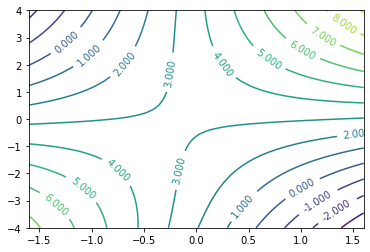

In [78]:
cp = plt.contour(x,y,Zp, levels=15)
plt.clabel(cp, inline=True, fontsize=10)
plt.show()

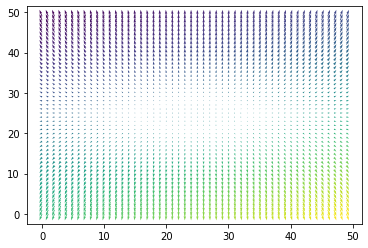

In [52]:
quiv = plt.quiver(X, Y, Zp,headlength = 5, color= 'g')
plt.show()

In [ ]:
Zp

array([[10.64624596, 10.34431934, 10.04158211, ..., -1.12708044,
        -1.56682372, -2.02335596],
       [10.69256973, 10.40286636, 10.11145782, ..., -0.85783172,
        -1.2942642 , -1.74799919],
       [10.7208662 , 10.4440937 , 10.16473007, ..., -0.58194488,
        -1.01425099, -1.46434247],
       ...,
       [-1.30452335, -0.85447627, -0.42225468, ..., 10.41609764,
        10.69812107, 10.97741318],
       [-1.57587421, -1.12227941, -0.68603319, ..., 10.36935329,
        10.66333389, 10.95546818],
       [-1.83824837, -1.3819406 , -0.94247228, ..., 10.30696201,
        10.61218834, 10.91645622]])

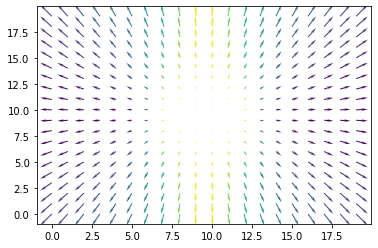

In [ ]:
Y, X = np.mgrid[-2:2:20j, -2:2:20j]
U =(1 - 2*(X**2))*np.exp(-((X**2)+(Y**2)))
V = -2*X*Y*np.exp(-((X**2)+(Y**2)))
speed = np.sqrt(U**2 + V**2)
UN = U/speed
VN = V/speed
quiv = plt.quiver(X, Y, UN,  # assign to var
           color='Teal', 
           headlength=7)

plt.show()